<a href="https://colab.research.google.com/github/GYIKOO/UCIMLHackathon21/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pd
import numpy as np

from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from keras.preprocessing.sequence import pad_sequences
from pathlib import Path
import matplotlib.pyplot as plt

In [179]:
# Config
save_model = Path('bertmodel.h5')

seed_val = 1 # random seed for training

MAX_LEN = 32
batch_size = 64

epochs = 1
checkpoint = 2

n_classes = 2 # num of labels

In [4]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
file_id = "1sDoHyJuEGe4R3rkgWp9r0R1zHWXAYGbNjwuuckQDthg"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('covid_lies.csv', mimetype='text/csv')

In [6]:
df = pd.read_csv('covid_lies.csv')
df = df.assign(related=[1]*len(df))
df.head()

,misconception_id,misconception,tweet,tweet_id,label,related
0,3,Coronavirus is genetically engineered.,How the COVID-19 outbreak is changing global p...,1.233965e+18,na,1
1,30,Blowing conch shells destroys coronavirus pote...,Getting coronavirus and then coughing on peopl...,1.233908e+18,na,1
2,57,Swans and dolphins swimming in Venice canals f...,Disturbing letter about life in COVID-19 ward ...,1.233910e+18,na,1
3,22,Cocaine cures coronavirus.,How to prevent corona virus?🤔 Use cowdung cake...,1.233948e+18,na,1
4,32,Observing janata curfew will result in the red...,This is concerning - They must self-insure for...,1.233937e+18,na,1


# Sample

The table of first 20 misconceptions.

In [142]:
miscon_df = df[['misconception_id','misconception']].drop_duplicates(subset='misconception_id').sort_values(by='misconception_id').reset_index(drop=True)
mini_mdf = miscon_df[:30].reset_index(drop=True)
mini_mdf = miscon_df
mini_mdf

,misconception_id,misconception
0,1,A person can tell if they have coronavirus or ...
1,2,Drinking large amounts of water will protect a...
2,3,Coronavirus is genetically engineered.
3,4,Dean Koontz predicted the pandemic in his 1981...
4,5,The first person infected is a researcher name...
...,...,...
57,58,Water polution decreased in Venice canals foll...
58,59,A Malabar civet was spotted walking the street...
59,60,A pod of humpback whales returned to the Arabi...
60,61,Lions were freed to keep people off the street...


The table of first 15 tweets.

In [141]:
tweets_df = df[['tweet_id','tweet']].drop_duplicates(subset='tweet').sort_values(by='tweet_id')
mini_tdf = tweets_df[:30].reset_index(drop=True)
mini_tdf = tweets_df
mini_tdf = mini_tdf.assign(tweet_index = [i for i in range(1,len(mini_tdf)+1)])
mini_tdf

,tweet_id,tweet,tweet_index
3212,1.230000e+18,How long does the new coronavirus remain activ...,1
3827,1.230000e+18,Millimetre wave technology will kill an indivi...,2
1146,1.230000e+18,How do we strengthen our immune systems to fig...,3
5497,1.233905e+18,"When it comes to coronavirus, who is the most ...",4
1624,1.233905e+18,#Coronavirus and China's Tax Response\n\n@USER...,5
...,...,...,...
2262,1.233998e+18,Forget the mask. Here's how to protect yoursel...,4342
3303,1.233998e+18,"Man Who Returned From Malaysia, Dies In Kerala...",4343
4058,1.233998e+18,.@miafarrow Dug up this report on exquisite ki...,4344
4385,1.233998e+18,Washington state health officials are investig...,4345


Connect all pairs of elements in the two tables. Mark existed relationships between misconception and tweet in original dataset as 'related'.

In [143]:
def merge_tweet_misconception(tdf, mdf, df):
    tdf = tdf.assign(tweet_index = [i for i in range(1,len(tdf)+1)])
    temp1 = tdf.loc[tdf.index.repeat(len(mdf))].reset_index(drop=True)

    full_table = temp1.assign(misconception_id = mdf.misconception_id.values.tolist()*len(tdf),
                  misconception = mdf.misconception.values.tolist()*len(tdf))

    sample = pd.merge(full_table, df,
         how = 'left',
         left_on = ['tweet_id','tweet','misconception_id','misconception'],
         right_on = ['tweet_id','tweet','misconception_id','misconception']
        ).drop(columns='label').fillna(0)
    sample.related = sample.related.astype('int64')
    sample.head()
    return sample

# Words Embedding

In [123]:
def vectorize(text,MAX_LEN=MAX_LEN):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    input_ids = []
    for t in text:
        # so basically encode tokenizing , mapping sentences to thier token ids after adding special tokens.
        encoded_sent = tokenizer.encode(
            t,  # Sentence which are encoding.
            add_special_tokens=True,  # Adding special tokens '[CLS]' and '[SEP]'
        )
        input_ids.append(encoded_sent)

    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN , truncating="post", padding="post")

    attention_masks = []
    for sent in input_ids:
        # Generating attention mask for sentences.
        #   - when there is 0 present as token id we are going to set mask as 0.
        #   - we are going to set mask 1 for all non-zero positive input id.
        att_mask = [int(token_id > 0) for token_id in sent]

        attention_masks.append(att_mask)

    return attention_masks, input_ids

In [124]:
m_text = miscon_df.misconception.values
m_attention_mask, m_input_id = vectorize(m_text)

t_text = tweets_df.tweet.values
t_attention_mask, t_input_id = vectorize(t_text,64)

In [125]:
def get_X_inputs_masks(sample, t_attention_mask, t_input_id, m_attention_mask, m_input_id):
    X_inputs = []
    X_masks = []

    for i in range(0,len(sample)):
        t_index = sample.tweet_index[i]-1
        inputs_temp = t_input_id[t_index].tolist().copy()
        masks_temp = t_attention_mask[t_index].copy()

        m_index = sample.misconception_id[i]-1
        inputs_temp.extend(m_input_id[m_index].tolist())
        masks_temp.extend(m_attention_mask[m_index])

        X_inputs.append(inputs_temp)
        X_masks.append(masks_temp)
    
    X_inputs = np.array(X_inputs)
    return X_inputs, X_masks

# Split Data

In [275]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


train_tdf, validation_tdf = train_test_split(mini_tdf, random_state=1, test_size=0.2)

# oversampling data to reduce the impact of data imbalance
sample = merge_tweet_misconception(train_tdf, mini_mdf, df)
oversample = sample.loc[sample[sample['related']==1].index.repeat(5)]
train_sample = pd.concat([sample,oversample]).reset_index(drop=True)
train_sample = shuffle(train_sample, random_state=1)
train_labels = train_sample.related.values
train_inputs, train_masks = get_X_inputs_masks(train_sample, t_attention_mask, t_input_id, m_attention_mask, m_input_id)

validation_sample = merge_tweet_misconception(validation_tdf, miscon_df, df)
validation_labels = validation_sample.related.values
validation_inputs, validation_masks = get_X_inputs_masks(validation_sample, t_attention_mask, t_input_id, m_attention_mask, m_input_id)

In [276]:
train_sample.groupby('related')['tweet'].count()

related
0    210269
1     31458
Name: tweet, dtype: int64

In [277]:
validation_sample.groupby('related')['tweet'].count()

related
0    52631
1     1309
Name: tweet, dtype: int64

# Class Weight

In [278]:
neg, pos = np.bincount(train_sample['related'])
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.57
Weight for class 1: 3.84


# Single Classifier

## Random Forest

In [289]:
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

def foresttrain(X_train, Y_train, model_name):
    '''
    Train the random forest classifier and save to local.
    :param X_train:
    :param Y_train:
    '''
    forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=3, class_weight = class_weight) #n_job is n of CPU cores assigned
    forest.fit(X_train, Y_train)
    dump(forest, model_name)

def forest_predict(X_val, model_name):
    '''
    comparing the return result with the Y_val
    e.g.
    from sklearn.metrics import accuracy_score
    accuracy_score(Y_val, forest_prediction)
    '''
    forest = load(model_name)
    forest_prediction = forest.predict(X_val)
    return forest_prediction

In [290]:
foresttrain(train_inputs, train_labels,'forest.joblib')

forest_pred = forest_predict(validation_inputs,'forest.joblib')

binary_eval(validation_labels,forest_pred)

overall accuracy 0.4998347823690079
f1 0.8975601280654669
roc_auc 0.4998347823690079
confusion matrix [[45698  6933]
 [ 1137   172]]


## Logistic Regression

In [293]:
from sklearn.linear_model import LogisticRegression

def lrtrain(X_train, Y_train, model_name):
    lr = LogisticRegression(n_jobs=5,solver='liblinear',class_weight=class_weight)
    lr.fit(X_train, Y_train)
    dump(lr,model_name)

def lr_predict(X_val, model_name):
    lr= load(model_name)
    lr_prediction = lr.predict(X_val)
    return lr_prediction

In [294]:
lrtrain(train_inputs, train_labels,'lr.joblib')

lr_pred = lr_predict(validation_inputs,'lr.joblib')

binary_eval(validation_labels,lr_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


overall accuracy 0.4951438717162787
f1 0.6888081121903076
roc_auc 0.4951438717162787
confusion matrix [[29041 23590]
 [  735   574]]


## Naive Bayes

In [284]:
from sklearn.naive_bayes import GaussianNB

def nbtrain(X_train, Y_train, model_name):
    '''
    Train the Naive Bayes classifer and save to local.
    :param X_train:
    :param Y_train:
    :return:
    '''
    nb = GaussianNB()
    nb.fit(X_train, Y_train)
    dump(nb, model_name)

def nb_predict(X_val, model_name):
    '''comparing the return result with the Y_val'''
    nb = load(model_name)
    nb_prediction = nb.predict(X_val)
    return nb_prediction

In [285]:
nbtrain(train_inputs, train_labels,'nb.joblib')

nb_pred = nb_predict(validation_inputs,'nb.joblib')

binary_eval(validation_labels,nb_pred)

overall accuracy 0.49990277089381063
f1 0.9450825315104764
roc_auc 0.49990277089381063
confusion matrix [[50530  2101]
 [ 1257    52]]


# Voting Emsemble

In [296]:
classfiers_pred = pd.DataFrame({'forest': forest_pred, 'nb': nb_pred, 'lr': lr_pred})

## Train Weight

In [291]:
def train_weight(preds, label, num=3):
    forest_pre = preds['forest'].values
    nb_pre = preds['nb'].values
    lr_pre = preds['lr'].values

    weight = [1]*num
    for i in range(0,len(label)):
        update = [0]*num
        wrong = 0
        
        if forest_pre[i] == label[i]:
            update[0] = 1
        else:
            wrong += 1

        if nb_pre[i] == label[i]:
            update[1] = 1
        else:
            wrong += 1

        if lr_pre[i] == label[i]:
            update[2] = 1
        else:
            wrong += 1

        for j in range(0,num):
            weight[j] += update[j]* wrong/num

    total_weight = sum(weight)
    for j in range(0, num):
        weight[j] = j/total_weight
    return weight

In [297]:
weight = train_weight(classfiers_pred,validation_labels)
print(weight)

[0.0, 5.370665425446881e-05, 0.00010741330850893762]


## Self-defined Voting

In [268]:
def WMVEpredict(weight, preds, use_softmax=False):
    softmax = torch.nn.Softmax()
    result = []
    forest_pre = preds['forest'].values
    nb_pre = preds['nb'].values
    lr_pre = preds['lr'].values

    for i in range(0, len(forest_pre)):
        labels = torch.FloatTensor([0,0])
        labels[forest_pre[i]] += weight[0]
        labels[nb_pre[i]] += weight[1]
        labels[lr_pre[i]] += weight[2]

        if use_softmax:
            votes = softmax(labels)
        else:
            votes = labels

        if votes[0] > votes[1]:
            result.append(0)
        elif votes[0] < votes[1]:
            result.append(1)
        else:
            result.append(randrange(2))
    return result

In [299]:
voting_pred = WMVEpredict(weight, classfiers_pred)
binary_eval(validation_labels,voting_pred)

overall accuracy 0.4951438717162787
f1 0.6888081121903076
roc_auc 0.4951438717162787
confusion matrix [[29041 23590]
 [  735   574]]
sensitivity 0.4385026737967914
specificity 0.551785069635766


## Voting from SKLearn

In [271]:
from sklearn.ensemble import VotingClassifier

forest = RandomForestClassifier(n_estimators=10, n_jobs=3, class_weight = class_weight)
lr = LogisticRegression(n_jobs=5,class_weight=class_weight)
nb = GaussianNB()

estimators = [('forest',forest), ('lr',lr), ('nb',nb)]

VotingCLF = VotingClassifier(estimators=estimators,
        flatten_transform=True)

In [288]:
voting = VotingCLF.fit(train_inputs,train_labels)

voting_pred = voting.predict(validation_inputs)
binary_eval(validation_labels,voting_pred)

overall accuracy 0.4994398276807325
f1 0.9615312603570133
roc_auc 0.4994398276807325
confusion matrix [[52371   260]
 [ 1304     5]]


# Deep Learning

In [175]:
# changing the numpy arrays into tensors for working on GPU.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation(test) set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

class_weight = torch.FloatTensor([weight_for_0,weight_for_1])

## Helper functions

In [176]:
from sklearn.metrics import confusion_matrix

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def flat_confusion_matrix(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return confusion_matrix(pred_flat,labels_flat,[0,1])

def plot_acc_loss(acc,loss):
    x1 = range(0, epochs)
    x2 = range(0, epochs)
    y1 = acc
    y2 = loss
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.show()

## Build Model

In [180]:
def bertpretrain(train_dataloader, validation_dataloader):
    
    if save_model.exists():
        model = torch.load(save_model)
    else:
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=n_classes,
            output_attentions=False,
            output_hidden_states=False
            )

    # Running the model on GPU.
    model.cuda()

    # Running on GPU if available, otherwise on CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    optimizer = AdamW(model.parameters(),
                      lr = 2e-5,
                      eps = 1e-8
                      )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value in run_glue.py
                                                num_training_steps=total_steps)

    # Set the seed value all over the place to make this reproducible.
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # Store the average loss after each epoch so we can plot them.
    loss_values = []

    val_accuracy = []

    # For each epoch...
    for epoch in range(0, epochs):

        # ========================================
        #               Training
        # ========================================
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_loss = 0

        model.train() # switch to training mode

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Clear any previously calculated gradients before performing a backward pass.
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            outputs = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)

            # Pull the loss value out of the tuple.
            #loss = outputs[0]
            ce = torch.nn.CrossEntropyLoss(weight=class_weight.to(device))
            loss = ce(outputs[1],b_labels)

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end.
            total_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


        # ========================================
        #         Validation
        # ========================================

        print("")
        print("Running Validation...")

        t0 = time.time() # Validation start time

        # Put the model in evaluation mode
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        val_conf_matrix = [np.array([0,0]),np.array([0,0])]
        nb_eval_steps, nb_eval_examples = 0, 0


        # Evaluate data for one epoch
        for batch in validation_dataloader:

            batch = tuple(t.to(device) for t in batch)


            b_input_ids, b_input_mask, b_labels = batch

            # Telling the model not to compute or store gradients, saving memory and
            # speeding up validation
            with torch.no_grad():
                outputs = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask)

            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits = outputs[0]

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            tmp_confusion_matrix = flat_confusion_matrix(logits,label_ids)

            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
            val_conf_matrix += tmp_confusion_matrix

            # Track the number of batches
            nb_eval_steps += 1

        # Report the final accuracy for this validation run.
        val_accuracy.append(eval_accuracy / nb_eval_steps)
        print("  Accuracy: {0:.2f}".format(eval_accuracy / nb_eval_steps))
        print("  Confusion matrix:", val_conf_matrix)
        print("  Validation took: {:}".format(format_time(time.time() - t0)))

        if epoch % checkpoint == 0:
          torch.save(model,save_model)
 

    print("Saving model...")
    torch.save(model, save_model)

    print("")
    print("Training complete!")

    return val_accuracy, loss_values, val_conf_matrix


In [178]:
val_accuracy, loss_values, val_conf_matrix = bertpretrain(train_dataloader, validation_dataloader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 1 ========
Training...
  Batch    40  of  4,187.    Elapsed: 0:00:23.
  Batch    80  of  4,187.    Elapsed: 0:00:45.
  Batch   120  of  4,187.    Elapsed: 0:01:08.
  Batch   160  of  4,187.    Elapsed: 0:01:30.
  Batch   200  of  4,187.    Elapsed: 0:01:52.
  Batch   240  of  4,187.    Elapsed: 0:02:15.
  Batch   280  of  4,187.    Elapsed: 0:02:37.
  Batch   320  of  4,187.    Elapsed: 0:03:00.
  Batch   360  of  4,187.    Elapsed: 0:03:22.
  Batch   400  of  4,187.    Elapsed: 0:03:45.
  Batch   440  of  4,187.    Elapsed: 0:04:07.
  Batch   480  of  4,187.    Elapsed: 0:04:30.
  Batch   520  of  4,187.    Elapsed: 0:04:52.
  Batch   560  of  4,187.    Elapsed: 0:05:15.
  Batch   600  of  4,187.    Elapsed: 0:05:37.
  Batch   640  of  4,187.    Elapsed: 0:05:59.
  Batch   680  of  4,187.    Elapsed: 0:06:22.
  Batch   720  of  4,187.    Elapsed: 0:06:44.
  Batch   760  of  4,187.    Elapsed: 0:07:07.
  Batch   800  of  4,187.    Elapsed: 0:07:29.
  Batch   840  of

In [95]:
# oversampling 5
train_conf_matrix 

array([[614,  76],
       [ 85,  50]])

In [96]:
# oversampling 5
val_conf_matrix

array([[272,   6],
       [ 93,   1]])

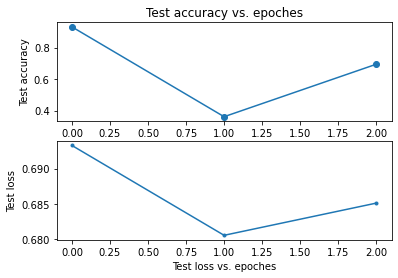

In [88]:
plot_acc_loss(val_accuracy,loss_values)

# Validation

In [295]:
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score, roc_auc_score

def binary_eval(label, prediction):
    print('overall accuracy', balanced_accuracy_score(label, prediction))
    print('f1',f1_score(label, prediction, average='weighted'))
    print('roc_auc', roc_auc_score(label, prediction, average='weighted'))
    c_matrix = confusion_matrix(label, prediction)
    print('confusion matrix', c_matrix)
    sensitivity = c_matrix[1][1]/(c_matrix[1][1]+c_matrix[1][0])
    specificity = c_matrix[0][0]/(c_matrix[0][0]+c_matrix[0][1])
    print('sensitivity',sensitivity)
    print('specificity',specificity)

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def bertpredict(model,inputs,masks):
    bert_pred = model(inputs.to(device),
              token_type_ids=None,
              attention_mask=masks.to(device))[0].detach().cpu().numpy()
    bertpred_class = np.argmax(bert_pred,axis=1).flatten()
    return bertpred_class

In [ ]:
bert = torch.load(save_model)

result = bertpredict(bert, validation_inputs, validation_masks)
binary_eval(validation_labels,result)